# Round 3
- calculate implied vol
- implement delta hedging

In [3]:
# !pip install -U prosperity3bt
!prosperity3bt "r4.py" 5-4 --match-trades worse --merge-pnl --vis

Backtesting G:\.shortcut-targets-by-id\1kCoYjL0gKyLojwoocZDIngh_T8m7DBqw\IMC Prosperity Event\Michael Work\r4.py on round 5 day 4
CROISSANTS: 0
DJEMBES: 0
JAMS: 0
KELP: 0
MAGNIFICENT_MACARONS: -1,851
PICNIC_BASKET1: 0
PICNIC_BASKET2: 0
RAINFOREST_RESIN: 0
SQUID_INK: 0
VOLCANIC_ROCK: 0
VOLCANIC_ROCK_VOUCHER_10000: 0
VOLCANIC_ROCK_VOUCHER_10250: 0
VOLCANIC_ROCK_VOUCHER_10500: 0
VOLCANIC_ROCK_VOUCHER_9500: 0
VOLCANIC_ROCK_VOUCHER_9750: 0
Total profit: -1,851

Successfully saved backtest results to backtests\2025-04-21_10-26-03.log



100%|##########| 10000/10000 [00:02<00:00, 3927.59it/s]


In [5]:
import pandas as pd

df = pd.read_csv("../resources/round3/trades_round_3_day_3.csv", sep=";")
# df = pd.read_csv("../r3/hist_data/test.csv", sep=";")
df = df[df["symbol"] != "MAGNIFICENT_MACARONS"]
# df = df.iloc[:, 1:]
print(df.dtypes)

# df.to_csv("../resources/round3/trades_round_3_day_3.csv", sep=";", index=False)

timestamp      int64
buyer        float64
seller       float64
symbol        object
currency      object
price        float64
quantity       int64
dtype: object


In [44]:
# Hint based trading #
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

df = pd.concat([pd.read_csv("../r3/hist_data/0.csv", sep=";"), pd.read_csv("../r3/hist_data/1.csv", sep=";")], ignore_index=True)
# df = pd.read_csv("../r3/hist_data/0.csv", sep=";")

u_df = df[df["product"] == "VOLCANIC_ROCK"].fillna(0)["mid_price"]
k95_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9500"].fillna(0)["mid_price"]
k97_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9750"].fillna(0)["mid_price"]
k100_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10000"].fillna(0)["mid_price"]
k102_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10250"].fillna(0)["mid_price"]
k105_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10500"].fillna(0)["mid_price"]


def half_d1(S, K, T_days):
    T = T_days / 10000
    return (np.log(K / S)) / np.sqrt(T)

# Implied volatility solver (daily volatility)
def black_scholes_call_daily_vol(S, K, T_days, r, sigma_daily):
    T = T_days / 10000  # Convert days to years
    sigma_annual = sigma_daily * 100
    d1 = (np.log(S / K) + (r + 0.5 * sigma_annual**2) * T) / (sigma_annual * np.sqrt(T))
    d2 = d1 - sigma_annual * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Implied volatility solver (daily volatility)
def implied_volatility_call(S, K, T_days, r, market_price, tol=1e-8, max_iterations=100):
    def objective_function(sigma_daily):
        return black_scholes_call_daily_vol(S, K, T_days, r, sigma_daily) - market_price

    try:
        iv_daily = brentq(objective_function, 1e-6, 5.0, xtol=tol, maxiter=max_iterations)
        return iv_daily
    except ValueError:
        # print(S,K,T_days,r,market_price)
        return 0

                        
# V_t = list()

# def implied_vol_solver(S, K, price, V_t):
#     for x in range(len(S)):
#         T = 70000-x
    
#         V_t.append(implied_volatility_call(S[x], K, T, 0., price[x])*100)
    
#         if x%5000==0:
#             print(x)

#     return half_d1(np.array(S), K, np.array([70000-x for x in range(20000)]))

# m_t = list(implied_vol_solver(np.array(u_df), 10500, np.array(k105_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 9750, np.array(k97_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 10000, np.array(k100_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 10250, np.array(k102_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 10500, np.array(k105_df), V_t))

# print(np.array(V_t).shape, np.array(m_t).shape)
# print(np.nonzero(np.array(m_t))[0])


def grid_search(iters_sqrt):
    best = (0,0,0)
    for x in range(iters_sqrt):
        for y in range(iters_sqrt)[x+(iters_sqrt//10):]:
            # first_bound = -0.025 + 0.035*x/iters_sqrt
            # second_bound = -0.025 + 0.035*y/iters_sqrt

            first_bound = -0.005

            idx_1 = (np.array(V_t) > 0.0025) & (np.array(m_t) < first_bound)
            idx_2 = (np.array(V_t) > 0.0025) & (np.array(m_t) > first_bound) # & (np.array(m_t) < second_bound)
            # idx_3 = (np.array(V_t) > 0.0025) & (np.array(m_t) > second_bound)
            
            reg_1 = np.polyfit(np.array(m_t)[idx_1], np.array(V_t)[idx_1], 2)
            reg_2 = np.polyfit(np.array(m_t)[idx_2], np.array(V_t)[idx_2], 2)
            # reg_3 = np.polyfit(np.array(m_t)[idx_3], np.array(V_t)[idx_3], 2)

            def r_squared(x, y, reg):
                a,b,c = reg
                y_pred = a*(x**2) + b*x + c
                ss_res = np.sum((y - y_pred) ** 2)         # Residual sum of squares
                ss_tot = np.sum((y - np.mean(y)) ** 2)     # Total sum of squares
                return 1 - (ss_res / ss_tot)

            def se(x,y,reg):
                a,b,c = reg
                y_pred = a*(x**2) + b*x + c
                residuals = y - y_pred
                sse = np.sum(residuals**2)
                n = len(y)
                mse = sse / (n - 2)
                return np.sqrt(mse)

            r_1 = r_squared(np.array(m_t)[idx_1], np.array(V_t)[idx_1], reg_1)
            r_2 = r_squared(np.array(m_t)[idx_2], np.array(V_t)[idx_2], reg_2)
            # r_3 = r_squared(np.array(m_t)[idx_3], np.array(V_t)[idx_3], reg_3)

            se_1 = se(np.array(m_t)[idx_1], np.array(V_t)[idx_1], reg_1)
            se_2 = se(np.array(m_t)[idx_2], np.array(V_t)[idx_2], reg_2)
            # se_3 = se(np.array(m_t)[idx_3], np.array(V_t)[idx_3], reg_3)

            r_score = r_1 * len(np.array(m_t)[idx_1]) + r_2 * len(np.array(m_t)[idx_2]) # + r_3 * len(np.array(m_t)[idx_3])

            if r_score > best[1]:
                # best = ((first_bound, second_bound), r_score, (reg_1, reg_2, reg_3), (se_1, se_2, se_3))
                best = (first_bound, r_score, (reg_1, reg_2), (se_1, se_2))
            break

    return best

# print(grid_search(2))

# idx1 = (np.array(V_t) > 0.0025) & (np.array(m_t) < -0.005)
# idx2 = (np.array(V_t) > 0.0025) & (np.array(m_t) > -0.005) # & (np.array(m_t) < 0.00466)
# print(np.array(m_t)[idx2])
# # idx3 = (np.array(V_t) > 0.0025) & (np.array(m_t) > 0.00466)
# idx = (np.array(V_t) > 0.0025)

# plt.scatter(np.array(m_t)[idx], np.array(V_t)[idx])
# plt.scatter(np.array(m_t)[idx1], 4.57831033*(np.array(m_t)[idx1]**2) + 0.03138129*np.array(m_t)[idx1] + 0.00876781)
# plt.scatter(np.array(m_t)[idx2], 3.07436614*(np.array(m_t)[idx2]**2) + 0.00885009*np.array(m_t)[idx2] + 0.00856192)
# # plt.scatter(np.array(m_t)[idx3], 4.71964979*(np.array(m_t)[idx3]**2) -  0.0310019*np.array(m_t)[idx3] +  0.00878236)

# # X_pre = m_t
# # y = V_t
# # poly = PolynomialFeatures(degree=2, include_bias=False)
# # X = poly.fit_transform(np.array(X_pre).reshape(-1,1))

# print(a,b,c)

y_predicted = 3.07436614*(np.array(m_t)[idx2]**2) + 0.00885009*np.array(m_t)[idx2] + 0.00856192
y_actual = np.array(V_t)[idx2]

residuals = y_actual - y_predicted
sse = np.sum(residuals**2)
print(residuals)
n = len(y_actual)
mse = sse / (n - 2)
standard_error = np.sqrt(mse)
print(standard_error)

# # base_m = half_d1(S.iloc[x], K, np.array([70000 - x for x in range(20000)]))
# # base_iv = a*(base_m**2)+b*base_m+c

# # plt.plot(range(20000), base_iv)

[ 2.80012344e-04  2.27012312e-04  2.66566902e-04 ...  6.01447473e-05
  2.85215769e-05 -1.69710885e-04]
9.505768006332737e-05


In [29]:
# IMPLIED VOLATILITY TRADING WITH DELTA HEDGING #
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

import math
from sklearn.linear_model import LinearRegression

# df = pd.concat([pd.read_csv("../r3/hist_data/0.csv", sep=";"), pd.read_csv("../r3/hist_data/1.csv", sep=";")], ignore_index=True)

# # u_df = df[df["product"] == "VOLCANIC_ROCK"].fillna(0)["mid_price"]
# # k95_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9500"].fillna(0)["mid_price"]
# # k97_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9750"].fillna(0)["mid_price"]
# # k100_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10000"].fillna(0)["mid_price"]
# # k102_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10250"].fillna(0)["mid_price"]
# # k105_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10500"].fillna(0)["mid_price"]

max_reg = (0,0)
params = 150
for delay in range(params)[80:]:
    print(delay)
    options_std = []
    for x in range(20000-delay):
        options_std.append(np.std(k105_df[x:x+delay]))
    
    # Variables to test: distance from strike price and timestamp #
    SK_diff = 10500 - u_df[delay:]
    T = np.array([7 - x/10000 for x in range(20000)[delay:]])
    
    X = np.array([SK_diff, T]).T
    y = options_std
    
    reg = LinearRegression().fit(X, y)
    if reg.score(X,y) > max_reg[1]:
        max_reg = (delay, reg.score(X,y))
    
print(max_reg)
    

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
(149, 0.2909260566071902)


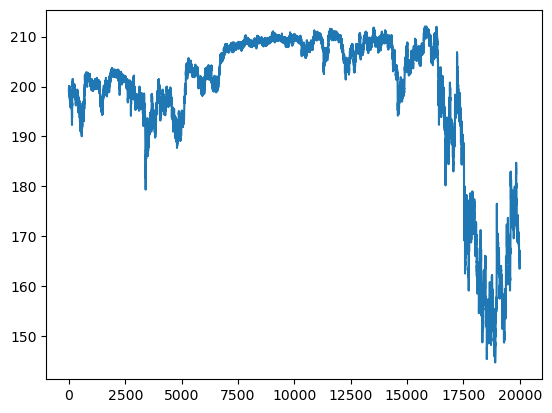

In [21]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

import math
from sklearn.linear_model import LinearRegression

df = pd.concat([pd.read_csv("../r3/hist_data/0.csv", sep=";"), pd.read_csv("../r3/hist_data/1.csv", sep=";")], ignore_index=True)

u_df = df[df["product"] == "VOLCANIC_ROCK"].fillna(0)
k95_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9500"].fillna(0)
k97_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9750"].fillna(0)
k100_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10000"].fillna(0)
k102_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10250"].fillna(0)
k105_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10500"].fillna(0)

##### BLACK SCHOLES ACCURACY TEST #####

def black_scholes(S, K, timestamp, r=0):
    T = 5 - (timestamp / 1000000)  # Convert days to years
    sigma = 0.0268
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * norm.cdf(d2)
    # print(norm.cdf(d2))
    return call_price

k95_bs = [black_scholes(u_df["mid_price"].iloc[x], 9500, x) for x in range(20000)]
k97_bs = [black_scholes(u_df["mid_price"].iloc[x], 9750, x) for x in range(20000)]
k100_bs = [black_scholes(u_df["mid_price"].iloc[x], 10000, x) for x in range(20000)]
k102_bs = [black_scholes(u_df["mid_price"].iloc[x], 10250, x) for x in range(20000)]
k105_bs = [black_scholes(u_df["mid_price"].iloc[x], 10500, x) for x in range(20000)]

# # X = [[k95_bs[x] - k95_df["mid_price"].iloc[x], 
# #       k97_bs[x] - k97_df["mid_price"].iloc[x],
# #       k100_bs[x] - k100_df["mid_price"].iloc[x], 
# #       k102_bs[x] - k102_df["mid_price"].iloc[x],
# #       k105_bs[x] - k105_df["mid_price"].iloc[x]] for x in range(20000)]

# X = np.array(9500 - u_df["mid_price"]).reshape(-1,1)
# y = [k95_bs[x] - k95_df["mid_price"].iloc[x] for x in range(20000)]

# reg = LinearRegression().fit(X, y)
# print(reg.score(X, y))

plt.plot(range(20000), k105_bs - k105_df["mid_price"])
# plt.plot(range(20000), 10500 - u_df["mid_price"])

# print(np.std(k105_bs - k105_df["mid_price"]))

In [43]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

import math
from sklearn.linear_model import LinearRegression

df = pd.concat([pd.read_csv("../r3/hist_data/0.csv", sep=";"), pd.read_csv("../r3/hist_data/1.csv", sep=";")], ignore_index=True)

u_df = df[df["product"] == "VOLCANIC_ROCK"].fillna(0)
k95_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9500"].fillna(0)
k97_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9750"].fillna(0)
k100_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10000"].fillna(0)
k102_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10250"].fillna(0)
k105_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10500"].fillna(0)

##### AUTOCORRELATION TEST #####

# from statsmodels.tsa.stattools import acf

# log_returns = np.log(np.array(k105_df["mid_price"])[1:]/np.array(k105_df["mid_price"])[:-1])
# acf_vals = acf(log_returns, nlags=500)
# print("Lag-1 autocorrelation:", acf_vals)


##### IMPLIED VOLATILITY TESTS #####

def black_scholes_call_daily_vol(S, K, T_days, r, sigma_daily):
    T = T_days / 10000  # Convert days to years
    sigma_annual = sigma_daily * 100
    d1 = (np.log(S / K) + (r + 0.5 * sigma_annual**2) * T) / (sigma_annual * np.sqrt(T))
    d2 = d1 - sigma_annual * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Implied volatility solver (daily volatility)
def implied_volatility_call(S, K, T_days, r, market_price, tol=1e-8, max_iterations=100):
    def objective_function(sigma_daily):
        return black_scholes_call_daily_vol(S, K, T_days, r, sigma_daily) - market_price

    try:
        iv_daily = brentq(objective_function, 1e-6, 5.0, xtol=tol, maxiter=max_iterations)
        return iv_daily
    except ValueError:
        return np.nan

# vol = list()

def test_vol(vol, strike, option):
    for x in range(len(u_df["mid_price"])):
        S = u_df["mid_price"].iloc[x]
        K = strike
        C = option["mid_price"].iloc[x]
        T = 70000-x
    
        vol.append(implied_volatility_call(S, K, T, 0., C)*100)

        if x%1000==0:
            print(x)
        
# test_vol(vol, 10250, k102_df)
# print(vol)

# plt.plot(range(10000), vol[0000:10000])

# u_prices = np.array(u_df["mid_price"])
# log_returns = np.log(u_prices[1:]/u_prices[:-1])
# print(np.mean(log_returns))
# print(np.std(log_returns) * 100)